In [87]:
import numpy as np 
import math 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import re

In [88]:
class Layer:
    def __init__(self, n_input, n_neuron):
        self.n_input = n_input
        self.n_neuron = n_neuron
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_neuron, n_input)) # weight matrix 
        self.b = np.zeros(n_neuron) 
        self.z = np.zeros(n_neuron) # z = Wx + b
        self.a = np.zeros(n_neuron) # a = f(z) 
        self.grad_z = np.zeros(n_neuron) 
        self.grad_a = np.zeros(n_neuron) 
        self.grad_W = np.zeros((n_neuron, n_input)) 
        self.grad_b = np.zeros(n_neuron) 
        
        self.next_layer = None
        self.prev_layer = None
        
        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        # self.grad_a_sum = self.grad_a
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b 

        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.z = self.W @ x + self.b  
        self.a = self.activation(self.z) 
    
    def activation(self, z):
        # logistic sigmoid
        # def temp(z) : return max( -500, min( 500, z )) 
        # vec_temp = np.vectorize(temp) 
        # z = vec_temp(z)  

        clipped_z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-clipped_z)) 
    
    def activation_derivative(self, z):
        # derivative of logistic sigmoid
        val = self.activation(z) 
        return val * (1 - val)  

    def compute_grad_a(self):
        if self.next_layer is not None:
            self.grad_a = self.next_layer.W.T @ self.next_layer.grad_z  
            # self.grad_a_sum += self.grad_a 
        else: # output layer
            pass 

    def compute_grad_z(self):
        self.grad_z = self.activation_derivative(self.z) * self.grad_a  # element-wise multiplication 
        # self.grad_z_sum += self.grad_z 

    def compute_grad_W(self):
        if (self.prev_layer is not None):
            self.grad_W = np.outer(self.grad_z, self.prev_layer.a)  
            self.grad_W_sum += self.grad_W 
        else: # input layer
            pass 

    def compute_grad_b(self):
        self.grad_b = self.grad_z 
        self.grad_b_sum += self.grad_b 
    
    def backward(self):
        
        self.compute_grad_a()
        self.compute_grad_z()
        self.compute_grad_W()
        self.compute_grad_b()
        

    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.a -= learning_rate * self.grad_a_sum / batch_size 
        # self.z -= learning_rate * self.grad_z_sum / batch_size 

        # self.grad_z_sum = np.zeros(self.n_neuron) 
        # self.grad_a_sum = np.zeros(self.n_neuron) 
        self.grad_W_sum = np.zeros((self.n_neuron, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_neuron)  

class InputLayer:
    def __init__(self, n_input):
        self.n_input = n_input
        self.n_neuron = n_input
        self.a = np.zeros(n_input) 
        self.next_layer = None
        self.prev_layer = None 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.a = x 

In [89]:
class OutputLayer:
    def __init__(self, n_input, n_classes):
        self.n_input = n_input
        self.n_classes = n_classes
        self.std_dev = np.sqrt(1 / n_input) # Xavier initialization
        self.W = np.random.normal(0,self.std_dev,(n_classes, n_input)) # weight matrix 
        self.b = np.zeros(n_classes) 
        self.z = np.zeros(n_classes) # z = Wx + b
        self.grad_z = np.zeros(n_classes) 
        self.grad_W = np.zeros((n_classes, n_input)) 
        self.grad_b = np.zeros(n_classes) 

        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b
        
        self.batch_loss = 0 
        self.phi = np.zeros(n_classes) # softmax(z) 
        self.next_layer = None
        self.prev_layer = None
        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
    
    def set_prev_layer(self, layer): # set next layer of the previous layer also 
        layer.next_layer = self 
        self.prev_layer = layer 

    def forward(self, x):
        self.z = self.W @ x + self.b  
        self.phi = self.softmax(self.z)  
    
    def softmax(self, z):
        # def temp(z) : return max( -500, min( 500, z )) 
        # vec_temp = np.vectorize(temp) 
        # z = vec_temp(z) 
        z = np.clip(z, -500, 500) 
        return np.exp(z) / np.sum(np.exp(z)) 

    def compute_loss(self, y):
        self.batch_loss -= np.log(self.phi[y])  
    
    def compute_grad_z(self, y):
        self.grad_z = self.phi 
        self.grad_z[y] -= 1
        # self.grad_z_sum += self.grad_z 
    
    def compute_grad_W(self):
        if (self.prev_layer is not None):
            self.grad_W = np.outer(self.grad_z, self.prev_layer.a) 
            self.grad_W_sum += self.grad_W 
        else: # input layer
            pass 
    
    def compute_grad_b(self):
        self.grad_b = self.grad_z
        self.grad_b_sum += self.grad_b
    
    def backward(self, y):
        
        self.compute_grad_z(y)
        self.compute_grad_W()
        self.compute_grad_b() 
    
    def weight_update(self, learning_rate, batch_size):
        # update parameters 
        self.W -= learning_rate * self.grad_W_sum / batch_size
        self.b -= learning_rate * self.grad_b_sum / batch_size
        # self.z -= learning_rate * self.grad_z_sum / batch_size 
        self.loss = self.batch_loss

        self.grad_W_sum = np.zeros((self.n_classes, self.n_input)) 
        self.grad_b_sum = np.zeros(self.n_classes)
        # self.grad_z_sum = np.zeros(self.n_classes) 
        self.batch_loss = 0 
        

In [90]:
class Neural_Network:
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        self.M = minibatch_size 
        self.n = no_of_features
        self.hidden_layers = hidden_layers 
        self.K = no_of_classes 
        self.training_data = None # should be already processed
        self.training_labels = None # should be already processed
        self.network = np.array([]) # array of layers 
        
    def make_network(self):
        input_layer = InputLayer(self.n) 
        self.network = np.append(self.network, input_layer) 
        for i in range(len(self.hidden_layers)):
            new_layer = Layer(self.network[-1].n_neuron, self.hidden_layers[i]) 
            new_layer.set_prev_layer(self.network[-1]) 
            self.network = np.append(self.network, new_layer) 
        
        output_layer = OutputLayer(self.network[-1].n_neuron, self.K) 
        output_layer.set_prev_layer(self.network[-1]) 
        self.network = np.append(self.network, output_layer) 
        print(f"printing network: {self.network}") 

    def forward_prop(self, x):
        self.network[0].forward(x) 
        for i in range(1, len(self.network)):
            self.network[i].forward(self.network[i-1].a) 
    
    def backward_prop(self, y):
        self.network[-1].compute_loss(y) 
        self.network[-1].backward(y) 
        for i in range(len(self.network)-2, 0, -1):
            self.network[i].backward()
    
    def weight_update(self, learning_rate):
        for i in range(1, len(self.network)):
            self.network[i].weight_update(learning_rate, self.M) 
        
    
    def shuffle(self, training_data, training_labels):
        idxs = np.array([i for i in range(len(training_data))]) 
        idx = np.random.shuffle(idxs)
        # print("shuffled idx is ", idxs) 
        training_data = training_data[idxs]
        training_labels = training_labels[idxs]
        return (training_data, training_labels)

    def train(self, training_eg, labels, learning_rate):
        self.training_eg, self.training_labels = self.shuffle(training_eg, labels)  
        # self.validation_split() 
        batches = len(self.training_eg) // self.M 
        self.training_eg = self.training_eg[:batches * self.M] 
        self.training_labels = self.training_labels[:batches * self.M] 
        # max_epochs = 1000
        max_epochs = 100
        epoch, cnt = 0, 0  
        tolerance, max_n_of_iter= 0.0001, 5 
        loss, prev_loss = 0,0
        n_of_iter = 0 
        while(n_of_iter < max_n_of_iter and epoch < max_epochs):
            for i in range(1, len(self.training_eg) + 1):
                self.forward_prop(self.training_eg[i - 1]) 
                self.backward_prop(int(self.training_labels[i - 1])) 
                cnt += 1 
                if (cnt % self.M == 0):
                    self.weight_update(learning_rate)  
                    cnt = 0 
            print(f"epoch {epoch} completed") 
            loss = self.network[-1].loss / self.M 
            print(f"loss is {loss}") 
            epoch += 1 
            if (abs(loss - prev_loss) < tolerance):
                n_of_iter += 1
            else : 
                n_of_iter = 0 

    def predict(self, x):
        self.forward_prop(x) 
        return np.argmax(self.network[-1].phi) 

    def compute_predictions(self, egs):
        correct = 0 
        predictions = [] 
        for i in range(len(egs)): predictions.append(self.predict(egs[i])) 
        return predictions

    def validation_split(self):
        validation_split_percent = 0.25 
        split = int(validation_split_percent * len(self.training_data)) 
        validation_eg = self.training_data[:split]
        self.training_eg = self.training_data[split:] 
        self.validation_eg = validation_eg 
        self.training_labels = self.training_labels[split:] 
        self.validation_labels = self.training_labels[:split] 
        return  
        

In [91]:
def get_input(input_path, output_path):
    x = np.load(input_path)
    y = np.load(output_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x,y

In [92]:
X_train, Y_train = get_input("../data/part b/x_train.npy", "../data/part b/y_train.npy") 
X_test, Y_test = get_input("../data/part b/x_test.npy", "../data/part b/y_test.npy" )
print(X_test.shape) 
print(Y_test.shape)
Y_train = Y_train - 1 
Y_test = Y_test - 1 

(1000, 1024)
(1000,)


In [93]:
# experimenting for part b 
# hidden_layers = np.array([[1], [5], [10], [50], [100]])
hidden_layers = [] 
nn_list = [] 
for hidden_layer in hidden_layers:
    nn = Neural_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.01) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

In [94]:
# plot by reading from logfile
def read_logfile():
    hidden_layer_sizes = [] 
    train_recall, test_recall = [[] for i in range(5)], [[] for i in range(5)] 
    train_precision, test_precision = [[] for i in range(5)], [[] for i in range(5)] 
    train_f1, test_f1 = [[] for i in range(5)], [[] for i in range(5)] 
    train_acc, test_acc= [], [] 
    in_train, in_test = False, False 
    with open("logfile", "r") as file:
        report = "" 
        lines = file.readlines()
        for line in lines:
            line = line.lstrip() 
            if (line.startswith("hidden_layer")):
                size = re.findall(r'\d+', line) 
                hidden_layer_sizes.append(int(size[0])) 
            elif (line.startswith("printing train report")):
                in_train = True
                in_test = False 
            elif (line.startswith("printing test report")):
                in_test = True 
                in_train = False

            elif (line.startswith("accuracy")):
                if (in_train):
                    acc = re.findall(r'\d+\.\d+', line)[0]
                    train_acc.append(float(acc))  
                elif (in_test):
                    acc = re.findall(r'\d+\.\d+', line)[0] 
                    test_acc.append(float(acc)) 

            elif (line.startswith("macro avg") or line.startswith("weighted avg")):
                continue 
            
            else:
                vals = re.findall(r'\d+\.\d+', line)
                if (len(vals) == 0): continue
                label = int(float(vals[0]))
                if (in_train):
                    train_recall[label].append(float(vals[2])) 
                    train_precision[label].append(float(vals[1])) 
                    train_f1[label].append(float(vals[3])) 
                elif (in_test):
                    test_recall[label].append(float(vals[2])) 
                    test_precision[label].append(float(vals[1])) 
                    test_f1[label].append(float(vals[3])) 
    return (hidden_layer_sizes, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc)
    

def plot_accuracies(y_lines, x, labels, x_label, y_label, name):

    fig,axis = plt.subplots()
    for y_line,label  in zip(y_lines, labels):
        axis.plot(x, y_line, label = label) 
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.legend()
    plt.grid(True)
    plt.savefig(f"{name}.pdf")
    plt.show()


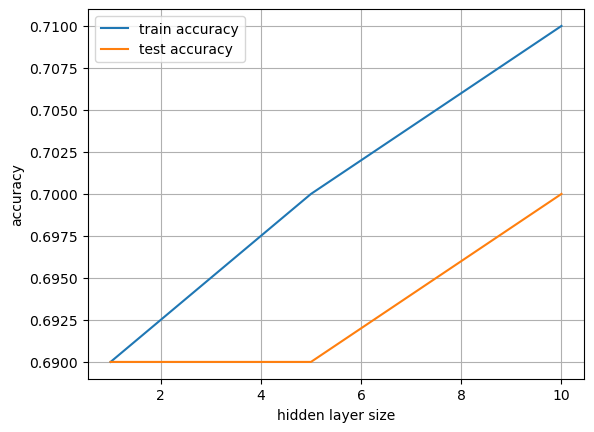

[0.672 0.694 0.706]
[[0.86 0.88 0.93]
 [0.65 0.69 0.74]
 [0.6  0.62 0.61]
 [0.49 0.53 0.49]
 [0.76 0.75 0.76]]


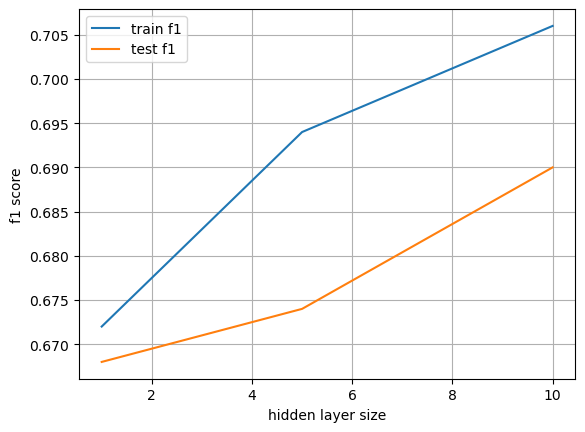

In [95]:
hidden_layers, train_recall, train_precision, train_f1, test_recall, test_precision, test_f1, train_acc, test_acc = read_logfile() 

# plotting train and test accuracies 
plot_accuracies([train_acc, test_acc], hidden_layers, ["train accuracy", "test accuracy"], "hidden layer size", "accuracy", "partb_accuracies") 
train_f1 = np.array(train_f1) 
train_f1_avg = np.mean(train_f1, axis = 0) 
test_f1 = np.array(test_f1)
test_f1_avg = np.mean(test_f1, axis = 0)
print(train_f1_avg)
print(train_f1) 
plot_accuracies([train_f1_avg, test_f1_avg], hidden_layers, ["train f1", "test f1"], "hidden layer size", "f1 score", "partb_f1")

# for i in range(1, 6):
#     for j in range(len(hidden_layers)):
#         print(f"for hidden layer {hidden_layers[j]}") 
#         print(f"class {i} train precision is {train_precision[i-1]}") 
#         print(f"class {i} test precision is {test_precision[i-1]}")
#         print(f"class {i} train recall is {train_recall[i-1]}")
#         print(f"class {i} test recall is {test_recall[i-1]}")
#         print(f"class {i} train f1 is {train_f1[i-1]}")
#         print(f"class {i} test f1 is {test_f1[i-1]}")
#         print()


## Comments
We see that f1 score is a good measure of generalization accuracy, since plots of test f1 score and test accuracy follow the same trend. Same holds for test data. 

In general, increasing the hidden layer size increases the test accuracy and test f1 score. 

We also observe that increasing the hidden layer size doesn't necessariliy increase f1 score. This could be due to overfitting of the model and loss of generalization accuracy with overly complex model . 

In [96]:
# experimenting for part b 
hidden_layers = [[512, 256, 128], [512, 256, 128, 64]] 
nn_list = [] 
for hidden_layer in hidden_layers:
    nn = Neural_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.05) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_c", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

printing network: [<__main__.InputLayer object at 0x0000013527E2B650>


epoch 0 completed
loss is 1.6028385905796056
epoch 1 completed
loss is 1.6008171449652189
epoch 2 completed
loss is 1.5980768014794304


In [ ]:
class AdaptiveNeuralNetwork(Neural_Network):
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        super().__init__(minibatch_size, no_of_features, hidden_layers, no_of_classes) 
        
    
    def train(self, training_eg, labels, seed):
        # adaptive learning rate = seed / sqrt(epoch) 
        self.training_eg, self.training_labels = self.shuffle(training_eg, labels)  
        # self.validation_split() 
        batches = len(self.training_eg) // self.M 
        self.training_eg = self.training_eg[:batches * self.M] 
        self.training_labels = self.training_labels[:batches * self.M] 
        # max_epochs = 1000
        max_epochs = 400 
        epoch, cnt = 0, 0  
        tolerance_seed, max_n_of_iter= 0.0001, 5 
        loss, prev_loss = 0,0
        n_of_iter = 0 
        while(n_of_iter < max_n_of_iter and epoch < max_epochs):
            for i in range(1, len(self.training_eg) + 1):
                self.forward_prop(self.training_eg[i - 1]) 
                self.backward_prop(int(self.training_labels[i - 1])) 
                cnt += 1 
                if (cnt % self.M == 0):
                    self.weight_update(seed / math.sqrt(epoch + 1))    
                    cnt = 0 
            print(f"epoch {epoch} completed") 
            loss = self.network[-1].loss / self.M 
            print(f"loss is {loss}") 
            epoch += 1 
            tolerance = tolerance_seed/ math.sqrt(epoch) 
            if (abs(loss - prev_loss) < tolerance):
                n_of_iter += 1
            else : 
                n_of_iter = 0 

In [ ]:
class RelU_Layer(Layer):
    def __init__(self, n_input, n_neuron):
        self.n_input = n_input
        self.n_neuron = n_neuron
        self.std_dev = np.sqrt(2 / n_input) # Xavier initialization for RelU 
        self.W = np.random.normal(0,self.std_dev,(n_neuron, n_input)) # weight matrix 
        self.b = np.zeros(n_neuron) 
        self.z = np.zeros(n_neuron) # z = Wx + b
        self.a = np.zeros(n_neuron) # a = f(z) 
        self.grad_z = np.zeros(n_neuron) 
        self.grad_a = np.zeros(n_neuron) 
        self.grad_W = np.zeros((n_neuron, n_input)) 
        self.grad_b = np.zeros(n_neuron) 
        
        self.next_layer = None
        self.prev_layer = None
        
        # self.grad_z_sum = self.grad_z  # will reset to 0 after each minibatch
        # self.grad_a_sum = self.grad_a
        self.grad_W_sum = self.grad_W
        self.grad_b_sum = self.grad_b 

        # if self.prev_layer is none then it is the input layer
        # if self.next_layer is none then it is the output layer 
       
    def temp(self, z) : return max( 0, z )

    def activation(self, z):
        # RelU 
        vec_temp = np.vectorize(self.temp) 
        return vec_temp(z) 
    
    def temp2(self, val) :
        if (val > 0): return 1 
        elif (val == 0): return 0.5 
        else : return 0  

    def activation_derivative(self, z):
        # derivative of logistic sigmoid
        vec_temp = np.vectorize(self.temp2) 
        return vec_temp(z)   

class RelU_OutputLayer(OutputLayer):
    def softmax(self, z):
        z = z - np.max(z) 
        try : return np.exp(z) / np.sum(np.exp(z)) 
        except OverflowError:
            def temp(z) : return max( -500, min( 500, z )) 
            vec_temp = np.vectorize(temp) 
            z = vec_temp(z) 
            return np.exp(z) / np.sum(np.exp(z)) 

class RelU_Network(AdaptiveNeuralNetwork):
    def __init__(self, minibatch_size, no_of_features, hidden_layers, no_of_classes):
        super().__init__(minibatch_size, no_of_features, hidden_layers, no_of_classes) 
    
    def make_network(self):
        input_layer = InputLayer(self.n) 
        self.network = np.append(self.network, input_layer) 
        for i in range(len(self.hidden_layers)):
            new_layer = RelU_Layer(self.network[-1].n_neuron, self.hidden_layers[i]) 
            new_layer.set_prev_layer(self.network[-1]) 
            self.network = np.append(self.network, new_layer) 
        
        output_layer = OutputLayer(self.network[-1].n_neuron, self.K) 
        output_layer.set_prev_layer(self.network[-1]) 
        self.network = np.append(self.network, output_layer) 
        print(f"printing network: {self.network}")

In [ ]:
# experimenting for part b 
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]] 
nn_list_2 = [] 
for hidden_layer in hidden_layers:
    nn = AdaptiveNeuralNetwork(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.05) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_d", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 

In [ ]:
# experimenting for part b 
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]] 
nn_list_2 = [] 
for hidden_layer in hidden_layers:
    nn = RelU_Network(32, 1024 , hidden_layer, 5) 
    nn.make_network() 
    nn.train(X_train, Y_train, 0.05) 
    train_pred = nn.compute_predictions(X_train) 
    test_pred = nn.compute_predictions(X_test) 
    report_test = classification_report( Y_test, test_pred)  
    report_train = classification_report(Y_train, train_pred) 
    to_print = f"hidden_layer is {hidden_layer}\n"
    to_print += "printing train report\n"
    to_print += "\n" + report_train + "\n"
    to_print += "printing test report\n"
    to_print += "\n" + report_test + "\n"
    print() 
    print()  
    with open("logfile_part_d", "a") as file:
        file.write(to_print)
    nn_list.append(nn) 
    # print(f"hidden layer is {hidden_layer}")
    # print(report)
    # print() 